## Imports


In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from math import sqrt


In [3]:
df = pd.read_csv("./dataset.csv")


def get_num_df(df):
    return df.select_dtypes(include=["int64", "float64"])


## Normalization


In [4]:
scaler = MinMaxScaler()
norm_df = pd.DataFrame(
    scaler.fit_transform(get_num_df(df)), columns=get_num_df(df).columns
)

# Removing ConvexArea from normalized dataset
norm_df_reduced = norm_df.drop(columns="ConvexArea", axis=1)

norm_df.describe()


,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter
count,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000
mean,0.297706,0.266050,0.317810,0.705602,0.258044,0.701609,0.263067
std,0.186026,0.150370,0.143414,0.147244,0.161733,0.117358,0.131701
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.161981,0.155267,0.216317,0.640756,0.140331,0.638749,0.167095
50%,0.255247,0.236080,0.298761,0.733812,0.220218,0.718859,0.240747
75%,0.379859,0.348025,0.390682,0.805095,0.326235,0.779492,0.331612
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Outliers


In [5]:
def get_outliers(df: pd.DataFrame, column: str):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    extreme_lower_bound = Q1 - 3 * IQR
    extreme_upper_bound = Q3 + 3 * IQR

    extreme_outliers = df[
        (df[column] < extreme_lower_bound) | (df[column] > extreme_upper_bound)
    ]

    mild_outliers = df[
        ((df[column] < lower_bound) | (df[column] > upper_bound))
        & ~(df[column] < extreme_lower_bound)
        & ~(df[column] > extreme_upper_bound)
    ]

    return (
        {"mild": mild_outliers.shape[0], "extreme": extreme_outliers.shape[0]},
        extreme_outliers.index,
        mild_outliers.index,
    )


def find_outlier_counts(df: pd.DataFrame) -> dict:
    outlier_counts = {}
    for column in df.select_dtypes(include=["number"]).columns:
        outlier_counts[column], _, _ = get_outliers(df, column)
    return outlier_counts


def find_outlier_indices(df: pd.DataFrame):
    outlier_indices = list()
    extreme_outlier_indices = list()

    for column in df.select_dtypes(include=["number"]).columns:
        _, eoi, oi = get_outliers(df, column)
        outlier_indices.extend(oi)
        extreme_outlier_indices.extend(eoi)

    unique_outlier_indices = np.unique(outlier_indices)
    unique_extreme_outlier_indices = np.unique(extreme_outlier_indices)

    return unique_extreme_outlier_indices, unique_outlier_indices


Identify mild/extreme outliers in normalized dataset, that does not include `ConvexArea`


In [6]:
outlier_counts_norm_df = find_outlier_counts(norm_df_reduced)

print("Outlier counts:")
for col, counts in outlier_counts_norm_df.items():
    print(f"{col} - Mild: {counts['mild']}, Extreme: {counts['extreme']}")

extreme_outlier_indices, outlier_indices = find_outlier_indices(norm_df_reduced)

print(f"\nTotal extreme outlier count: {len(extreme_outlier_indices)}")
print(f"Total mild outlier count: {len(outlier_indices)}\n")


Outlier counts:
Area - Mild: 41, Extreme: 0
MajorAxisLength - Mild: 14, Extreme: 3
MinorAxisLength - Mild: 25, Extreme: 1
Eccentricity - Mild: 38, Extreme: 5
Extent - Mild: 18, Extreme: 3
Perimeter - Mild: 15, Extreme: 2

Total extreme outlier count: 10
Total mild outlier count: 100



## Remove extreme outliers:


In [7]:
norm_df_reduced_clean: pd.DataFrame = norm_df_reduced.drop(extreme_outlier_indices)

_, outlier_indices = find_outlier_indices(norm_df_reduced_clean)


In [8]:
norm_df_reduced_clean["MildOutlier"] = 0

norm_df_reduced_clean.loc[outlier_indices, "MildOutlier"] = 1

norm_df_reduced_clean["Class"] = df["Class"]

norm_df_reduced_clean.to_csv("./clean_dataset.csv", index=False)


## Correlation analysis


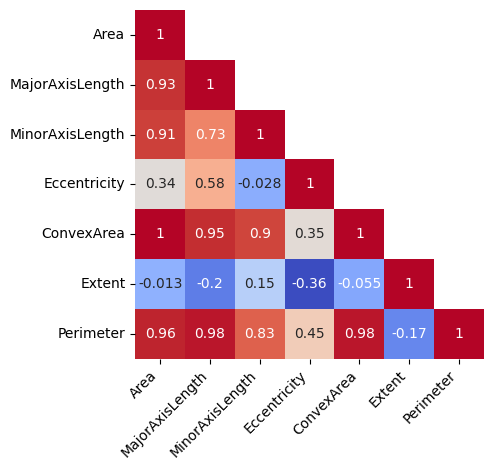

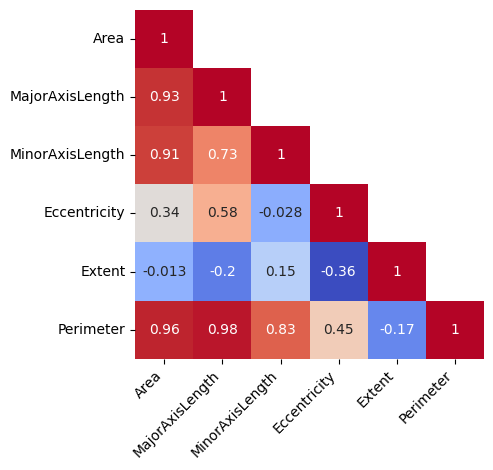

In [21]:
corr_full = norm_df.corr()
mask_full = np.triu(np.ones_like(corr_full, dtype=bool), 1)

sns.heatmap(
    corr_full,
    mask=mask_full,
    annot=True,
    cbar=False,
    cmap="coolwarm",
    square=True,
)
plt.xticks(rotation=45, horizontalalignment="right")
plt.tight_layout()
plt.show()

corr_reduced = norm_df_reduced.corr()
mask_reduced = np.triu(np.ones_like(corr_reduced, dtype=bool), 1)

sns.heatmap(
    corr_reduced,
    mask=mask_reduced,
    annot=True,
    cbar=False,
    cmap="coolwarm",
    square=True,
)
plt.xticks(rotation=45, horizontalalignment="right")
plt.tight_layout()
plt.show()


## Optimal Cluster Number


### Empirical Method


In [10]:
def empirical_method(df):
    num_rows = df.shape[0]
    k_empirical = int(sqrt(num_rows / 2))
    print(f"Empirical method suggests {k_empirical} clusters")


empirical_method(norm_df_reduced_clean)


Empirical method suggests 21 clusters


### Elbow Method


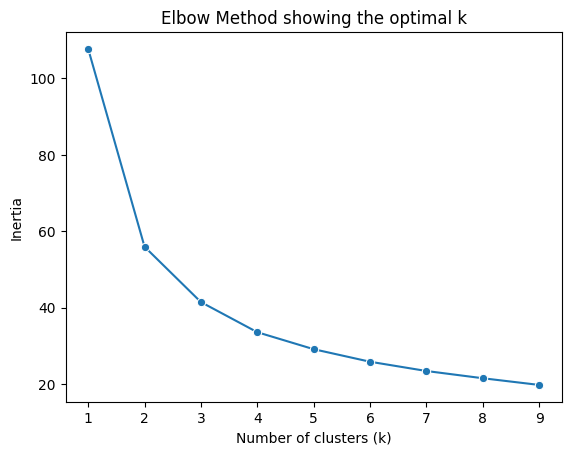

In [11]:
def elbow_method(df):
    inertia = []
    K = range(1, 10)

    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(df)
        inertia.append(kmeans.inertia_)
    sns.lineplot(x=K, y=inertia, marker="o")
    plt.title("Elbow Method showing the optimal k")
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Inertia")
    plt.show()


elbow_method(norm_df_reduced_clean.drop(columns=["MildOutlier", "Class"]))


### Silhouette method


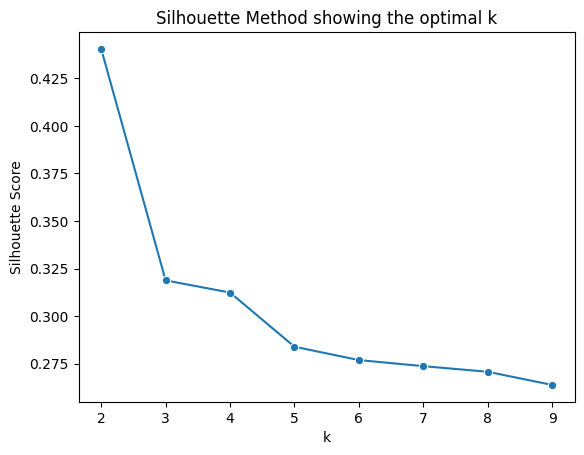

In [12]:
def silhouette_method(df):
    silhouette_scores = []

    K = range(1, 10)

    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(df)
        if k == 1:
            continue  # silhouette_score requires more than one cluster to work
        score = silhouette_score(df, kmeans.labels_)
        silhouette_scores.append(score)
    sns.lineplot(x=K[1:], y=silhouette_scores, marker="o")
    plt.xlabel("k")
    plt.ylabel("Silhouette Score")
    plt.title("Silhouette Method showing the optimal k")
    plt.show()


silhouette_method(norm_df_reduced_clean.drop(columns=["MildOutlier", "Class"]))
